In [255]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [256]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [257]:
IN_DIR = "/Users/loblium/data/ptv/"
OUT_DIR = "/Users/loblium/data/ptv/"

In [258]:
ptv_result = np.zeros((1, 6))

In [259]:
for i in tqdm(range(0, 3900, 1)):
    try:
        r = np.loadtxt(IN_DIR +f"10/{i}.csv", delimiter=',', skiprows=1)
    except StopIteration:
        r = None
    except OSError:
        r = None

    if r is None:
        pass
    elif r.ndim == 1:
        if len(r) > 0:
            r = r[np.newaxis, :]
            ptv_result = np.vstack([ptv_result, r])

    elif r.ndim == 2:
        ptv_result = np.vstack([ptv_result, r])

100%|██████████| 3900/3900 [00:01<00:00, 3849.32it/s]


In [260]:
ptv_result = pd.DataFrame(ptv_result, columns=['x', 'y', 'dx', 'dy', 'p0', 'p1'])
for row in ptv_result.index:
    if (ptv_result.loc[row] == 0).all():
        ptv_result.drop(row, axis=0, inplace=True)

In [261]:
px_to_m = 10 / 34 / 1e3

In [262]:
ptv_result['x'] = 2704 - ptv_result['x']
ptv_result['y'] = 1520 - ptv_result['y']
ptv_result['dx'] = - ptv_result['dx']
ptv_result['dy'] = - ptv_result['dy']

In [263]:
ptv_result['x'] = ptv_result['x'] + 378
ptv_result['y'] = ptv_result['y'] - 675

In [264]:
ptv_result['x'] *= px_to_m
ptv_result['y'] *= px_to_m
ptv_result['dx'] *= px_to_m * 120
ptv_result['dy'] *= px_to_m * 120

In [265]:
ptv_result['r'] = np.sqrt(ptv_result['x']**2 + ptv_result['y']**2)
ptv_result['theta'] = np.arctan2(ptv_result['y'], ptv_result['x'])
ptv_result['dr'] = ptv_result['dx'] * np.cos(ptv_result['theta']) + ptv_result['dy'] * np.sin(ptv_result['theta'])

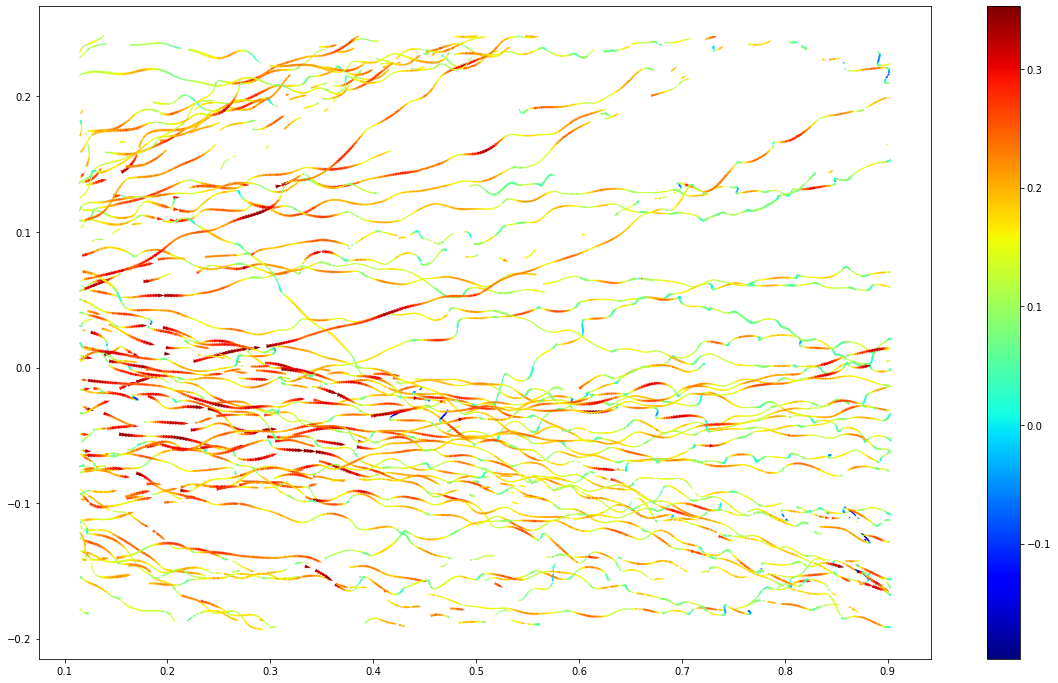

In [266]:
fig, ax = plt.subplots(figsize=(20, 12))
c = ax.quiver(ptv_result['x'], ptv_result['y'], ptv_result['dx'], ptv_result['dy'], ptv_result['dr'], cmap="jet")
fig.colorbar(c)
plt.show()

In [267]:
with open(f'6.pickle', mode='wb') as fp:
    pickle.dump(ptv_result, fp)

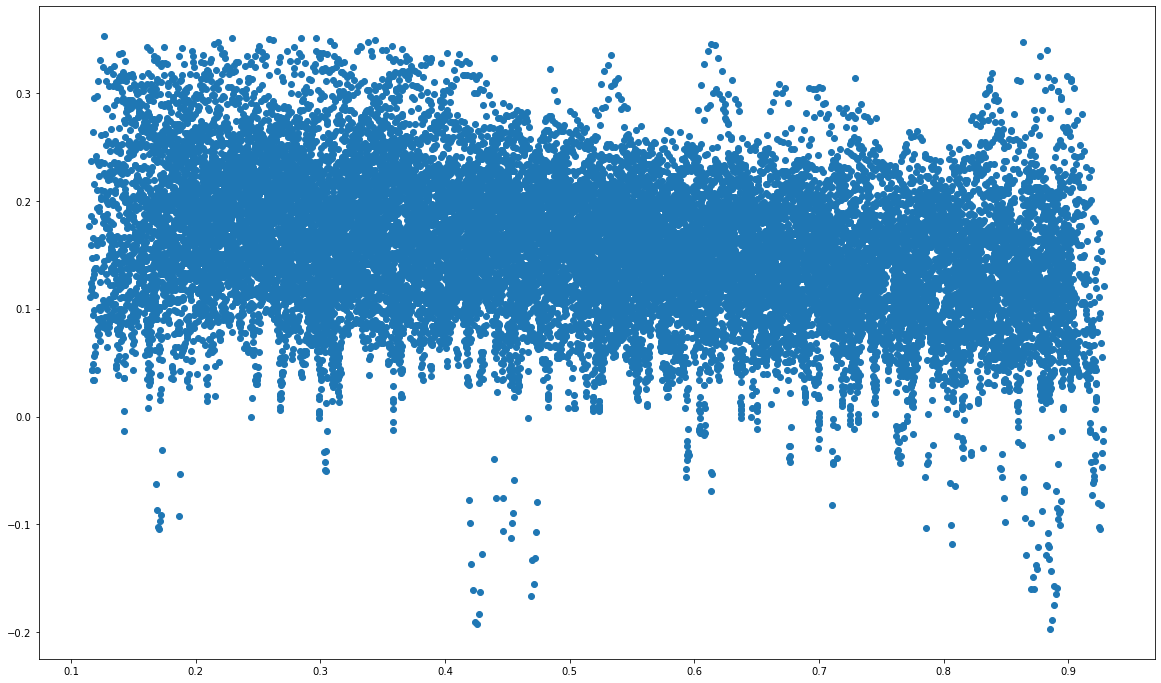

In [268]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(ptv_result['r'], ptv_result['dr'])
plt.show()

In [269]:
res_sort = ptv_result.sort_values(by='r', ascending=True).values

In [270]:
_iter = 5
res = []
res2 = []

In [271]:
r_dr_err = np.zeros((1001, 3))
r_dr_in = np.zeros((1, 2))
r_dr_err[:, :] = np.nan
r_dr_in[:, :] = np.nan

for i in tqdm(range(0, 1001, _iter)):
    res_sort_l = res_sort[np.where(res_sort[:, 6] >= i/1000)]
    res_sort_lr = res_sort_l[np.where(res_sort_l[:, 6] < (i+_iter)/1000)]
    columns = ['x', 'y', 'dx', 'dy', 'p0', 'p1', 'r', 'theta', 'dr']
    df = pd.DataFrame(data=res_sort_lr, columns=columns, dtype='float')
    q1 = df['dr'].quantile(0.25)
    q2 = df['dr'].quantile(0.75)
    iqr = q2 - q1

    upper = q2 + 1.5 * iqr
    bottom = q1 - 1.5 * iqr
    _in = df[(df['dr'] >= bottom) & (df['dr'] <= upper)].values
    tmp = np.array([_in[:, 6], _in[:, 8]]).T
    r_dr_in = np.vstack([r_dr_in, tmp])

    r_dr_err[i, 0] = i
    r_dr_err[i, 1] = np.mean(tmp, axis=0)[1]
    r_dr_err[i, 2] = np.std(tmp, axis=0)[1]

r_dr_err = r_dr_err[::_iter]
res = r_dr_err
res2 = r_dr_in

100%|██████████| 201/201 [00:00<00:00, 662.21it/s]


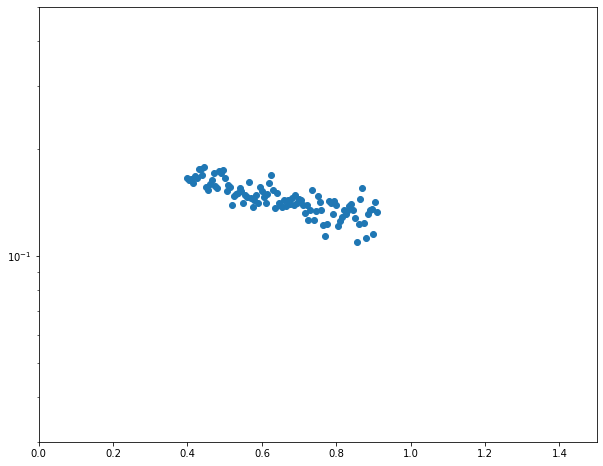

In [286]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.xlim(0, 1.5)
plt.ylim(0.03, 0.5)
ax.set_yscale("log")
ax.scatter(res[80:-18, 0]/1000, res[80:-18, 1])
plt.show()

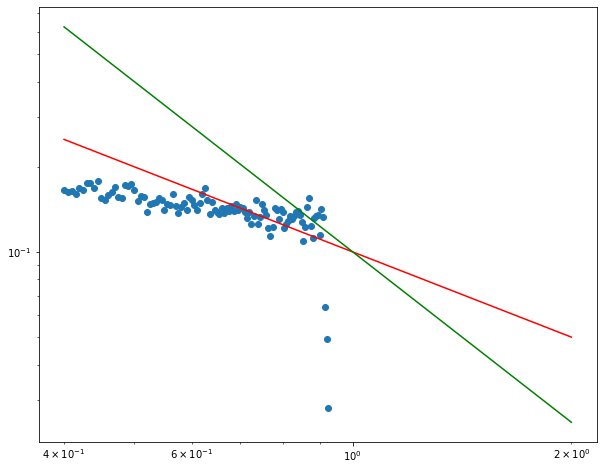

In [272]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xscale("log")
ax.set_yscale("log")
ax.scatter(res[80:, 0]/1000, res[80:, 1])
ax.plot(np.linspace(0.4, 2, 100), 1 / np.linspace(0.4, 2, 100) * 0.1, c='r')
ax.plot(np.linspace(0.4, 2, 100), 1 / np.linspace(0.4, 2, 100)**2 * 0.1, c='g')
plt.show()